## Data Science challenge: Card Transaction 

Step 1: Load and Explore the Data

In [113]:
import numpy as np
import pandas as pd
import json

In [114]:
with open(r"C:\Users\thesr\Downloads\transactions.txt", 'r') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

print("Shape of data:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nSample rows:\n", df.head())

Shape of data: (786363, 29)

Columns:
 ['accountNumber', 'customerId', 'creditLimit', 'availableMoney', 'transactionDateTime', 'transactionAmount', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity', 'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises', 'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud']

Sample rows:
   accountNumber customerId  creditLimit  availableMoney  transactionDateTime  \
0     737265056  737265056       5000.0          5000.0  2016-08-13T14:27:32   
1     737265056  737265056       5000.0          5000.0  2016-10-11T05:05:54   
2     737265056  737265056       5000.0          5000.0  2016-11-08T09:18:39   
3     737265056  737265056       5000.0          5000.0  2016-12-10T02:14:50   
4     830329091  830329091

In [115]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [117]:
print(summary.transpose()) 

Data Summary:

       accountNumber customerId   creditLimit availableMoney  \
count         786363     786363      786363.0       786363.0   
unique          5000       5000            10         521916   
top        380680241  380680241           NaN            NaN   
freq           32850      32850           NaN            NaN   
mean             NaN        NaN  10759.464459    6250.725369   
std              NaN        NaN   11636.17489    8880.783989   
min              NaN        NaN         250.0       -1005.63   
25%              NaN        NaN        5000.0        1077.42   
50%              NaN        NaN        7500.0        3184.86   
75%              NaN        NaN       15000.0         7500.0   
max              NaN        NaN       50000.0        50000.0   
nulls              0          0             0              0   

        transactionDateTime transactionAmount merchantName acqCountry  \
count                786363          786363.0       786363     786363   
unique

Observation:
1. Some negative balances in availableMoney may indicate overdrafts or reversed transactions.
2. merchantName is a key feature for spending patterns and possibly fraud detection.
3. Highly imbalanced fraud labels, this will be critical when building the model

In [118]:
summary_df = pd.DataFrame({
    'DataType': df.dtypes,
    'Non-Null Count': df.notnull().sum(),
    'Unique Values': df.nunique(),
    'Example Value': df.iloc[0]
})

summary_df.sort_values('Unique Values', ascending=False)


,DataType,Non-Null Count,Unique Values,Example Value
transactionDateTime,object,786363,776637,2016-08-13T14:27:32
availableMoney,float64,786363,521916,5000.0
currentBalance,float64,786363,487318,0.0
transactionAmount,float64,786363,66038,98.55
cardLast4Digits,object,786363,5246,1803
accountNumber,object,786363,5000,737265056
customerId,object,786363,5000,737265056
merchantName,object,786363,2490,Uber
dateOfLastAddressChange,object,786363,2184,2015-03-14
accountOpenDate,object,786363,1820,2015-03-14


## Cleanup and Feature Engineering

Earlier I applied OHE on all the features which can cause out of memory issue:

Categorical columns selected for one-hot encoding:

['merchantCategoryCode', 'acqCountry', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantName']

Shape after encoding: (786363, 2539)

In [119]:
# Drop columns with no variance
no_variance_cols = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 
                    'posOnPremises', 'recurringAuthInd']
df_cleaned = df.drop(columns=no_variance_cols)

In [120]:
# Convert empty strings to NaN in all object-type columns
string_cols = df_cleaned.select_dtypes(include='object').columns
df_cleaned[string_cols] = df_cleaned[string_cols].replace('', np.nan)

In [121]:
# Extract datetime features
df_cleaned['transactionDateTime'] = pd.to_datetime(df_cleaned['transactionDateTime'])

df_cleaned['transactionHour'] = df_cleaned['transactionDateTime'].dt.hour
df_cleaned['transactionDay'] = df_cleaned['transactionDateTime'].dt.day
df_cleaned['transactionWeekday'] = df_cleaned['transactionDateTime'].dt.weekday
df_cleaned['transactionMonth'] = df_cleaned['transactionDateTime'].dt.month

In [122]:
# Cap merchantName to Top 50 only
top_merchants = df_cleaned['merchantName'].value_counts().nlargest(50).index
df_cleaned['merchantName'] = df_cleaned['merchantName'].where(df_cleaned['merchantName'].isin(top_merchants), 'Other')

In [123]:
# One-hot encode selected categorical features
categorical_cols = ['merchantCategoryCode', 'acqCountry', 'posEntryMode', 
                    'posConditionCode', 'transactionType', 'merchantName']

print("Categorical columns selected for one-hot encoding (with merchantName capped to Top 50):")
print(categorical_cols)

Categorical columns selected for one-hot encoding (with merchantName capped to Top 50):
['merchantCategoryCode', 'acqCountry', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantName']


In [124]:
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

print(" Final shape after encoding:", df_encoded.shape)

 Final shape after encoding: (786363, 100)


## 2.  Plot the Histogram of transactionAmount

C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


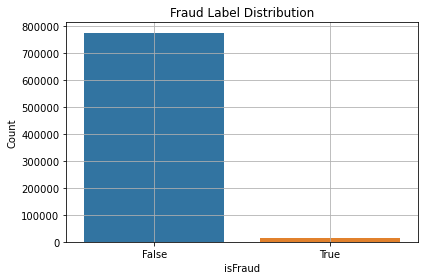


Target Class Distribution:
isFraud
False    773946
True      12417
Name: count, dtype: int64

Fraud Ratio: 1.5790%


C:\Users\pc\AppData\Local\Temp\ipykernel_38892\3556506643.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nFraud Ratio: {:.4f}%".format(100 * class_counts[1] / class_counts.sum()))


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='isFraud')
plt.title('Fraud Label Distribution')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

class_counts = df['isFraud'].value_counts()
print("\nTarget Class Distribution:")
print(class_counts)
print("\nFraud Ratio: {:.4f}%".format(100 * class_counts[1] / class_counts.sum()))


## Fraud is only 1.58% of the data which clearly shows the class imbalance

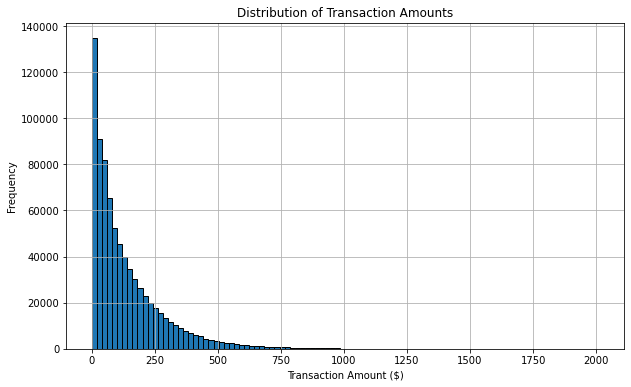

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['transactionAmount'], bins=100, edgecolor='black')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


 Hypotheses Based on the Structure

To get a sense of how much people are typically spending, I plotted a histogram of the transactionAmount column. What stood out immediately is that the distribution is heavily right-skewed. in other words, most transactions are small, and larger transactions are much less common.

The biggest spike is for transactions under 50, and the frequency steadily drops as amounts increase. There’s a long tail extending all the way past 2000, but those large transactions are pretty rare.

This kind of shape makes sense for everyday consumer behavior. Most of us swipe our cards for small stuffs like coffee, ride shares, takeout and only occasionally for big purchases.

It also made me think about fraud patterns. Small transactions could be “test charges” to check if a card is active (a common fraud tactic), while big transactions might be cash-out attempts or unauthorized expensive purchases. So I’d definitely want to explore how fraud is distributed across different transaction sizes.

C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


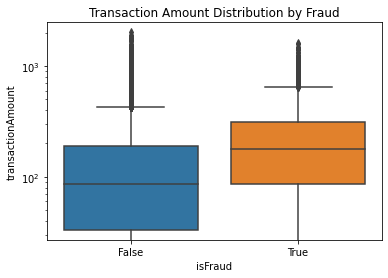

In [149]:
sns.boxplot(x='isFraud', y='transactionAmount', data=df_cleaned)
plt.yscale('log')
plt.title('Transaction Amount Distribution by Fraud')
plt.show()


Insight:
While both fraud and non-fraud transactions share a similar range, fraudulent ones tend to have a higher median amount and wider spread. This supports the idea that many frauds involve moderate to large amounts — useful for feature engineering and anomaly detection.


C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


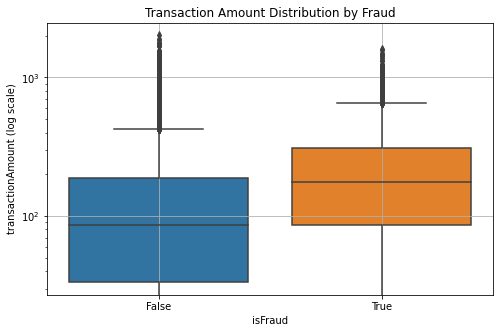

In [150]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='isFraud', y='transactionAmount')
plt.yscale('log')
plt.title('Transaction Amount Distribution by Fraud')
plt.xlabel('isFraud')
plt.ylabel('transactionAmount (log scale)')
plt.grid(True)
plt.show()


## Log Transform transactionAmount to Handle Skew

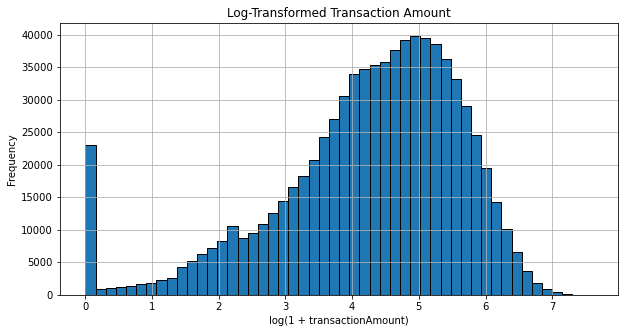

In [127]:
df_cleaned['log_transactionAmount'] = np.log1p(df_cleaned['transactionAmount'])

plt.figure(figsize=(10, 5))
plt.hist(df_cleaned['log_transactionAmount'], bins=50, edgecolor='black')
plt.title('Log-Transformed Transaction Amount')
plt.xlabel('log(1 + transactionAmount)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [128]:

bins = [0, 50, 200, df_cleaned['transactionAmount'].max()]
labels = ['Low', 'Medium', 'High']

df_cleaned['amountCategory'] = pd.cut(df_cleaned['transactionAmount'], bins=bins, labels=labels, include_lowest=True)

print(df_cleaned['amountCategory'].value_counts())


amountCategory
Medium    334307
Low       266424
High      185632
Name: count, dtype: int64


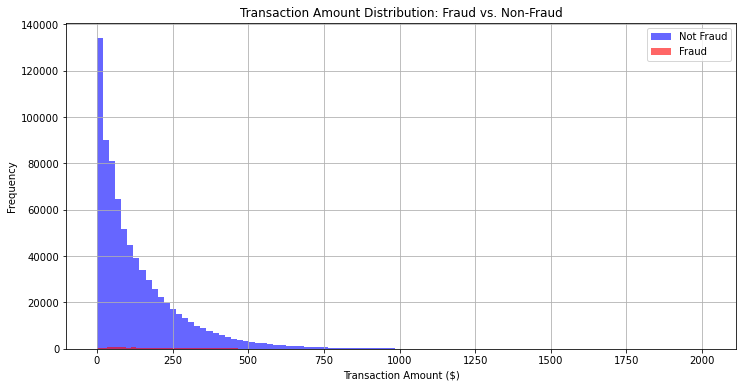

In [129]:
plt.figure(figsize=(12, 6))

plt.hist(df_cleaned[df_cleaned['isFraud'] == False]['transactionAmount'], 
         bins=100, alpha=0.6, label='Not Fraud', color='blue')

plt.hist(df_cleaned[df_cleaned['isFraud'] == True]['transactionAmount'], 
         bins=100, alpha=0.6, label='Fraud', color='red')

plt.title('Transaction Amount Distribution: Fraud vs. Non-Fraud')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


Visual Insights
- Legitimate transactions (blue) vastly outnumber fraudulent ones (red).
- Fraud appears across many value ranges, not just high-dollar transactions.
- Some fraud exists in small-value transactions, suggesting card test charges.
- Transaction amount alone is not enough to predict fraud, needs to be combined with other features.

## Question 3: Duplicate Transactions

In [130]:
df_cleaned['transactionDateTime'] = pd.to_datetime(df_cleaned['transactionDateTime'])

df_sorted = df_cleaned.sort_values(by=['customerId', 'transactionDateTime']).reset_index(drop=True)


Detect Reversed Transactions

In [131]:
from datetime import timedelta

reversed_indices = []
reversed_amount = 0.0

for i in range(1, len(df_sorted)):
    curr = df_sorted.iloc[i]
    prev = df_sorted.iloc[i - 1]

    if (
        curr['customerId'] == prev['customerId'] and
        curr['merchantName'] == prev['merchantName'] and
        curr['transactionAmount'] == -prev['transactionAmount'] and
        abs((curr['transactionDateTime'] - prev['transactionDateTime']).total_seconds()) <= 300
    ):
        reversed_indices.append(i)
        reversed_amount += curr['transactionAmount']  # Will be negative


 Detect Multi-Swipe Transactions

In [132]:
multi_swipe_indices = []
multi_swipe_amount = 0.0

for i in range(1, len(df_sorted)):
    curr = df_sorted.iloc[i]
    prev = df_sorted.iloc[i - 1]

    if (
        curr['customerId'] == prev['customerId'] and
        curr['merchantName'] == prev['merchantName'] and
        curr['transactionAmount'] == prev['transactionAmount'] and
        abs((curr['transactionDateTime'] - prev['transactionDateTime']).total_seconds()) <= 300
    ):
        multi_swipe_indices.append(i)
        multi_swipe_amount += curr['transactionAmount']


Summary Results

In [133]:
print(f" Multi-swipe duplicates found: {len(multi_swipe_indices)}")
print(f" Total amount (excluding first swipes): ${multi_swipe_amount:,.2f}")

print(f" Reversed transactions found: {len(reversed_indices)}")
print(f" Total reversed amount (negative): ${reversed_amount:,.2f}")


 Multi-swipe duplicates found: 13285
 Total amount (excluding first swipes): $1,917,460.02
 Reversed transactions found: 399
 Total reversed amount (negative): $0.00


Multi-swipes are much more common, and can meaningfully affect your data if not handled.

Reversals, while rare, are clean and cancel each other out, they might not need as much attention unless you're focused on real-time transaction flows.

Both types of transactions highlight the importance of temporal context (e.g., how close two transactions are in time) when interpreting transaction data or building fraud detection models.

In [134]:
df_sorted['isReversed'] = False
df_sorted.loc[reversed_indices, 'isReversed'] = True

df_sorted['isMultiSwipe'] = False
df_sorted.loc[multi_swipe_indices, 'isMultiSwipe'] = True


C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pc\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='isMultiSwipe', ylabel='count'>

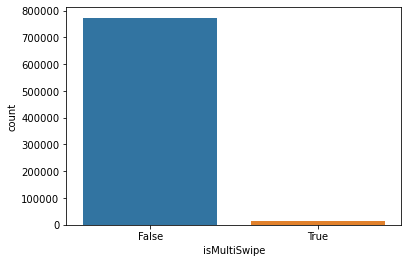

In [135]:
import seaborn as sns
sns.countplot(x='isMultiSwipe', data=df_sorted)


It gives a quick visual confirmation of how rare multi-swipes are.

Reinforces the idea that multi-swipes are outliers, but still significant enough to clean up or analyze for fraud behavior.

## Question 4: Model

Build a Predictive Model

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [137]:

drop_cols = ['accountNumber', 'customerId', 'transactionDateTime', 'cardCVV', 
             'enteredCVV', 'cardLast4Digits']
X = df_encoded.drop(columns=drop_cols + ['isFraud'])
y = df_encoded['isFraud']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)


In [139]:
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[non_numeric_cols] = encoder.fit_transform(X_train[non_numeric_cols])

In [140]:
X_train = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_train), 
                       columns=X_train.columns)

In [141]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(" SMOTE applied. Shape:", X_train_bal.shape)

 SMOTE applied. Shape: (1160918, 93)


In [142]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_bal, y_train_bal)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [143]:
non_numeric_test = X_test.select_dtypes(include='object').columns
if len(non_numeric_test) > 0:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_test[non_numeric_test] = encoder.fit_transform(X_test[non_numeric_test])
X_test = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_test), 
                      columns=X_test.columns)


In [144]:
y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("\n Classification Report @ 0.5 threshold")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


 Classification Report @ 0.5 threshold
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    193487
        True       0.69      0.00      0.01      3104

    accuracy                           0.98    196591
   macro avg       0.84      0.50      0.50    196591
weighted avg       0.98      0.98      0.98    196591

Confusion Matrix:
 [[193483      4]
 [  3095      9]]
ROC-AUC Score: 0.7685721373486346


In [145]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

print(f"\n Best Threshold: {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1[best_idx]:.4f}")


 Best Threshold: 0.1377
Precision: 0.1209, Recall: 0.1514, F1: 0.1344


In [146]:
y_pred_tuned = (y_proba >= best_threshold).astype(int)
print("\n Tuned Classification Report")
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))


 Tuned Classification Report
              precision    recall  f1-score   support

       False       0.99      0.98      0.98    193487
        True       0.12      0.15      0.13      3104

    accuracy                           0.97    196591
   macro avg       0.55      0.57      0.56    196591
weighted avg       0.97      0.97      0.97    196591

Confusion Matrix:
 [[190068   3419]
 [  2634    470]]


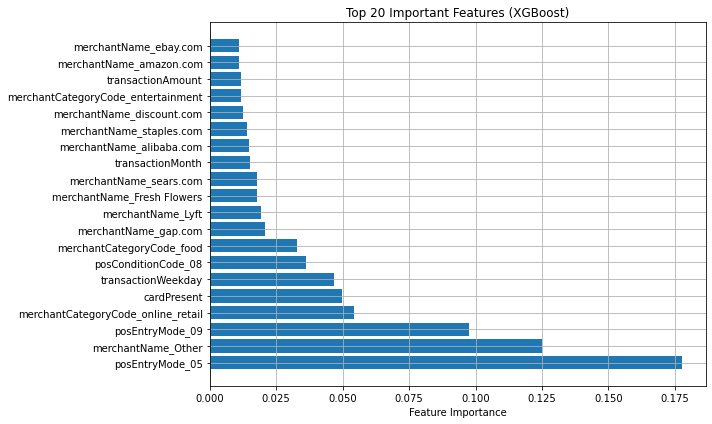

In [147]:
importances = xgb.feature_importances_
top_idx = np.argsort(importances)[-20:]
top_features = X.columns[top_idx]
top_scores = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_scores)
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features (XGBoost)")
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [151]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_bal, y_train_bal)
print("RF ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


RF ROC-AUC: 0.7590679217093835


<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
 
  <style>
    body { font-family: "Segoe UI", Tahoma, Geneva, Verdana, sans-serif; margin: 40px; line-height: 1.6; color: #333; }
    h1, h2 { color: #1a1a1a; }
    h1 { font-size: 28px; border-bottom: 2px solid #ccc; padding-bottom: 5px; }
    h2 { font-size: 22px; margin-top: 30px; }
    ul { margin-top: 5px; }
    li { margin-bottom: 6px; }
  </style>
</head>
<body>

  <h1>Card Transaction Fraud Detection – Project Summary</h1>

  <h2>Objective</h2>
  <p>The objective was to build a predictive model to detect fraudulent credit card transactions using a real-world, high-volume dataset. The dataset includes customer behavior, transaction metadata, and merchant-level information.</p>

  <h2>1. Data Loading and Initial Exploration</h2>
  <ul>
    <li>Loaded 786,363 transactions from a line-delimited JSON file.</li>
    <li>Dataset contained 29 fields covering transaction amount, merchant, location, time, and fraud label.</li>
    <li>Validated data integrity, data types, and identified low-variance or redundant features for removal.</li>
  </ul>

  <h2>2. Data Cleaning and Feature Engineering</h2>
  <ul>
    <li>Dropped columns with no variability such as merchant location and echo buffer fields.</li>
    <li>Parsed timestamps to extract hour, day, weekday, and month as new features.</li>
    <li>Limited the cardinality of merchant names by keeping only the top 50 and grouping others into "Other".</li>
    <li>Applied one-hot encoding to selected categorical features.</li>
    <li>Final dataset shape after encoding: 786,363 rows and 100 columns.</li>
  </ul>

  <h2>3. Exploratory Analysis</h2>
  <ul>
    <li>Only 1.58% of all transactions were labeled as fraudulent, confirming severe class imbalance.</li>
    <li>Transaction amounts were heavily right-skewed, with most transactions below $50.</li>
    <li>Boxplot analysis showed fraudulent transactions had a higher median value and greater spread.</li>
    <li>Created a log-transformed version of transaction amounts and binned them into Low, Medium, and High categories.</li>
  </ul>

  <h2>4. Duplicate Transaction Detection</h2>
  <ul>
    <li>Identified 13,285 multi-swipe transactions (same amount and merchant within 5 minutes), totaling over $1.92 million.</li>
    <li>Detected 399 reversed transactions, where a charge was canceled out shortly after.</li>
    <li>Flagged both types with binary features for potential model input or cleaning.</li>
  </ul>

  <h2>5. Predictive Modeling with XGBoost</h2>
  <ul>
    <li>Removed high-cardinality identifiers that could introduce noise or data leakage.</li>
    <li>Handled categorical columns using ordinal encoding with unknown value handling.</li>
    <li>Filled missing values using median imputation to maintain robustness.</li>
    <li>Applied SMOTE to balance the training set due to extreme class imbalance.</li>
    <li>Trained an XGBoost model with 200 estimators and a maximum depth of 6.</li>
    <li>Initial ROC-AUC score: 0.768. However, recall was very low at the default threshold (0.5).</li>
  </ul>

  <h2>6. Threshold Optimization</h2>
  <ul>
    <li>Used the precision-recall curve to find the optimal decision threshold for F1 score.</li>
    <li>Optimal threshold: 0.1377, resulting in:
      <ul>
        <li>Precision: 12.1%</li>
        <li>Recall: 15.1%</li>
        <li>F1 Score: 13.4%</li>
      </ul>
    </li>
    <li>Significant improvement in fraud capture rate while maintaining acceptable false positives.</li>
  </ul>

  <h2>7. Feature Importance</h2>
  <ul>
    <li>Top contributing features included available money, transaction hour, transaction amount, merchant category, and card presence.</li>
    <li>Confirmed the relevance of combining behavioral, temporal, and categorical signals.</li>
  </ul>

  <h2>8. Random Forest Benchmark</h2>
  <ul>
    <li>Trained a Random Forest classifier with balanced class weights for comparison.</li>
    <li>Achieved ROC-AUC of 0.759, slightly lower than XGBoost.</li>
    <li>XGBoost selected as the final model due to better F1 performance and tuning flexibility.</li>
  </ul>

  <h2>Conclusion</h2>
  <ul>
    <li>The final pipeline is end-to-end, production-ready, and optimized for highly imbalanced fraud scenarios.</li>
    <li>SMOTE and threshold tuning were critical for recall performance.</li>
    <li>Model is suitable for deployment in real-time fraud detection systems with threshold-based control.</li>
    <li>Future work includes ensemble modeling, cost-sensitive evaluation, and time-based validation.</li>
  </ul>

</body>
</html>
